In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils import data

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing,
                                              EqOddsPostprocessing,
                                              RejectOptionClassification)
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
random_state = 1

mps


pip install 'aif360[AdversarialDebiasing]'


In [2]:
# read in data and split
X = torch.load('inputs/rfw_senet50_face_embeddings.pt').cpu()
y = torch.load('inputs/rfw_senet50_labels.pt').cpu()
df = pd.read_csv('inputs/rfw_senet50_df.csv')
df['reference_ethnicity'] = df['reference_ethnicity'].str.lower()
ethnicity = df['reference_ethnicity'].to_numpy()

df

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,labels
0,m.0c7mh2,m.0c7mh2,african,African,1.0
1,m.0c7mh2,m.0c7mh2,african,African,1.0
2,m.026tq86,m.026tq86,african,African,1.0
3,m.026tq86,m.026tq86,african,African,1.0
4,m.02wz3nc,m.02wz3nc,african,African,1.0
...,...,...,...,...,...
29311,m.0402tg,m.01npnk3,caucasian,Caucasian,0.0
29312,m.05pbbnj,m.02rrb2n,caucasian,Caucasian,0.0
29313,m.09j6df,m.07kcsqd,african,African,0.0
29314,m.0fhrbz,m.025zgjt,african,African,0.0


In [3]:
matches = df[df.labels==1]
non_matches = df[df.labels==0]
print(non_matches['reference_ethnicity'].value_counts())
print(matches['reference_ethnicity'].value_counts())

african      7464
caucasian    7194
Name: reference_ethnicity, dtype: int64
african      7420
caucasian    7238
Name: reference_ethnicity, dtype: int64


In [4]:
7194*4

28776

In [5]:
african_matches = matches[matches['reference_ethnicity']=='african']
caucasian_matches = matches[matches['reference_ethnicity']=='caucasian']

african_non_matches = non_matches[non_matches['reference_ethnicity']=='african']
caucasian_non_matches = non_matches[non_matches['reference_ethnicity']=='caucasian']


In [6]:
np.random.seed(random_state)
african_matches_sub_idx = african_matches.index[np.random.choice(len(african_matches.index), size=7194, replace=False)]
caucasian_matches_sub_idx = caucasian_matches.index[np.random.choice(len(caucasian_matches.index), size=7194, replace=False)]
african_non_matches_sub_idx = african_non_matches.index[np.random.choice(len(african_non_matches.index), size=7194, replace=False)]
caucasian_non_matches_sub_idx = caucasian_non_matches.index

In [7]:
X_sub = torch.cat([X[african_matches_sub_idx],X[caucasian_matches_sub_idx],X[african_non_matches_sub_idx],X[caucasian_non_matches_sub_idx]])
y_sub = torch.cat([y[african_matches_sub_idx],y[caucasian_matches_sub_idx],y[african_non_matches_sub_idx],y[caucasian_non_matches_sub_idx]])
ethnicity_sub = np.concatenate([ethnicity[african_matches_sub_idx],ethnicity[caucasian_matches_sub_idx],ethnicity[african_non_matches_sub_idx],ethnicity[caucasian_non_matches_sub_idx]])
df_sub = pd.concat([df.iloc[african_matches_sub_idx],df.iloc[caucasian_matches_sub_idx],df.iloc[african_non_matches_sub_idx],df.iloc[caucasian_non_matches_sub_idx]])
df_sub

,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,labels
2012,m.04ztpp,m.04ztpp,african,African,1.0
925,m.01q5qp8,m.01q5qp8,african,African,1.0
2688,m.064h70,m.064h70,african,African,1.0
2000,m.04mvcl,m.04mvcl,african,African,1.0
4442,m.07rjwr,m.07rjwr,african,African,1.0
...,...,...,...,...,...
29304,m.02p_9kj,m.01_pll,caucasian,Caucasian,0.0
29307,m.0hl3d,m.0415yw4,caucasian,Caucasian,0.0
29308,m.02qrwlw,m.0g8k46,caucasian,Caucasian,0.0
29311,m.0402tg,m.01npnk3,caucasian,Caucasian,0.0


In [8]:
train_split, test_split = train_test_split(np.arange(len(X_sub)),test_size=0.2, random_state=random_state)
train_split, val_split = train_test_split(train_split,test_size=0.25, random_state=random_state)
X_train = X_sub[train_split]
X_val = X_sub[val_split]
X_test = X_sub[test_split]
y_train = y_sub[train_split]
y_val = y_sub[val_split]
y_test = y_sub[test_split]

ethnicity_train = ethnicity_sub[train_split]
# ethnicity_train[ethnicity_train=='caucasian'] = 0
# ethnicity_train[ethnicity_train=='african'] = 1
# ethnicity_train = ethnicity_train.astype(int)

ethnicity_val = ethnicity_sub[val_split]
# ethnicity_val[ethnicity_val=='caucasian'] = 0
# ethnicity_val[ethnicity_val=='african'] = 1
# ethnicity_val = ethnicity_val.astype(int)

ethnicity_test = ethnicity_sub[test_split]
# ethnicity_test[ethnicity_test=='caucasian'] = 0
# ethnicity_test[ethnicity_test=='african'] = 1
# ethnicity_test = ethnicity_test.astype(int)

df_train = df_sub.iloc[train_split]
df_test = df_sub.iloc[test_split]
df_val = df_sub.iloc[val_split]

cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
def confusion_mat(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = (tn + tp)/(tn+tp+fn+fp)
    return tn, fp, fn, tp, acc

In [9]:
matches = df_train[df_train.labels==1]
non_matches = df_train[df_train.labels==0]
print(non_matches['reference_ethnicity'].value_counts())
print(matches['reference_ethnicity'].value_counts())

caucasian    4374
african      4323
Name: reference_ethnicity, dtype: int64
caucasian    4292
african      4276
Name: reference_ethnicity, dtype: int64


In [10]:
train_cos = cos_sim(X_train[:,:2048],X_train[:,2048:])
thresholds = np.arange(0,1.001,0.001)
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    pred = (train_cos>thresh)*1
    tn, fp, fn, tp, acc = confusion_mat(pred, y_train.numpy())
    tnr_list.append(tn/(tn+fp))
    tpr_list.append(tp/(tp+fn))
    fnr_list.append(fn/(fn+tp))
    fpr_list.append(fp/(fp+tn))
    acc_list.append(acc)


  0%|          | 0/1001 [00:00<?, ?it/s]

In [11]:
def solve(f,x):
    s = np.sign(f)
    z = np.where(s == 0)[0]
    if z:
        return z
    else:
        s = s[0:-1] + s[1:]
        z = np.where(s == 0)[0]
        return z

def interp(f,x,z):
    m = (f[z+1] - f[z]) / (x[z+1] - x[z])
    return x[z] - f[z]/m
f = np.array(fnr_list)-np.array(fpr_list)
z = solve(f,thresholds)
ans = interp(f,thresholds,z)
ans

array([0.49319422])

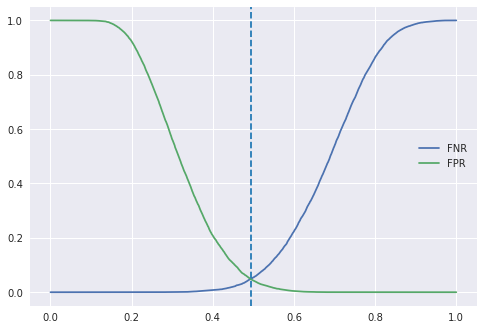

In [12]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,fnr_list,label='FNR')
    plt.plot(thresholds,fpr_list,label='FPR')
    # plt.plot(thresholds,np.array(fnr_list)-np.array(fpr_list))
    plt.axvline(x=ans,linestyle ='--')
    plt.legend()
plt.show()

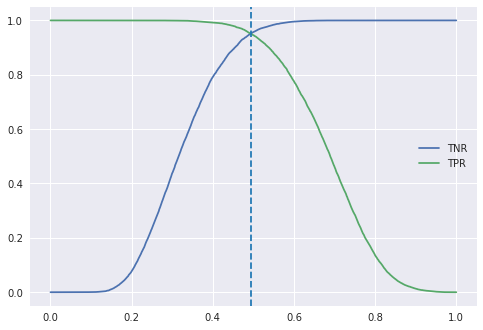

In [13]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,tnr_list,label='TNR')
    plt.plot(thresholds,tpr_list,label='TPR')
    plt.legend()
    plt.axvline(x=ans,linestyle ='--')
plt.show()

In [14]:
thresholds[np.where(acc_list==np.max(acc_list))]


array([0.497])

In [15]:
print(thresholds[np.abs(thresholds-ans).argmin()])
print(thresholds[acc_list == max(acc_list)])

0.493
[0.497]


In [16]:
eer_thresh = 0.493
acc_thresh = 0.497
eer_pred = (train_cos>eer_thresh)*1
acc_pred = (train_cos>acc_thresh)*1
df_bias = df_train.drop(['reference_identity','candidate_identity','candidate_ethnicity'],axis=1)
df_bias['eer_pred'] = eer_pred
df_bias['acc_pred'] = acc_pred
df_bias_african = df_bias[df_bias['reference_ethnicity']=='african']
df_bias_caucasian = df_bias[df_bias['reference_ethnicity']=='caucasian']
df_bias_african

,reference_ethnicity,labels,eer_pred,acc_pred
4765,african,1.0,1,1
25366,african,0.0,0,0
26289,african,0.0,0,0
5326,african,1.0,1,1
4125,african,1.0,1,1
...,...,...,...,...
22875,african,0.0,0,0
16382,african,0.0,0,0
3677,african,1.0,1,1
5825,african,1.0,1,1


In [17]:
african_eer_tn, african_eer_fp, african_eer_fn, african_eer_tp, african_eer_acc = confusion_mat(df_bias_african['eer_pred'], df_bias_african['labels'])

caucasian_eer_tn, caucasian_eer_fp, caucasian_eer_fn, caucasian_eer_tp, caucasian_eer_acc = confusion_mat(df_bias_caucasian['eer_pred'], df_bias_caucasian['labels'])

african_acc_tn, african_acc_fp, african_acc_fn, african_acc_tp, african_acc_acc = confusion_mat(df_bias_african['acc_pred'], df_bias_african['labels'])

caucasian_acc_tn, caucasian_acc_fp, caucasian_acc_fn, caucasian_acc_tp, caucasian_acc_acc = confusion_mat(df_bias_caucasian['acc_pred'], df_bias_caucasian['labels'])

In [18]:
african_eer_tnr = african_eer_tn/(african_eer_tn+african_eer_fp)
african_eer_tpr = african_eer_tp/(african_eer_tp+african_eer_fn)
african_eer_fnr = african_eer_fn/(african_eer_fn+african_eer_tp)
african_eer_fpr = african_eer_fp/(african_eer_tn+african_eer_fp)

caucasian_eer_tnr = caucasian_eer_tn/(caucasian_eer_tn+caucasian_eer_fp)
caucasian_eer_tpr = caucasian_eer_tp/(caucasian_eer_tp+caucasian_eer_fn)
caucasian_eer_fnr = caucasian_eer_fn/(caucasian_eer_fn+caucasian_eer_tp)
caucasian_eer_fpr = caucasian_eer_fp/(caucasian_eer_tn+caucasian_eer_fp)

print(african_eer_fnr/caucasian_eer_fnr)
print(african_eer_fpr/caucasian_eer_fpr)
print(caucasian_eer_tnr/african_eer_tnr)
print(caucasian_eer_tpr/african_eer_tpr)
print((1-african_eer_acc)/(1-caucasian_eer_acc))

0.2930177968612914
7.763996091149854
1.0829924830478461
0.9457676644635533
1.276717125949264


In [19]:
print('african fnr:',african_eer_fnr,'caucasian fnr:',caucasian_eer_fnr)
print('african fpr:',african_eer_fpr,'caucasian fpr:',caucasian_eer_fpr)
print('african tnr:',caucasian_eer_tnr,'caucasian tnr:',african_eer_tnr)
print('african tpr:',caucasian_eer_tpr,'caucasian tpr:',african_eer_tpr)
print('african mis class:',(1-african_eer_acc),'caucasian mis class:',(1-caucasian_eer_acc))

african fnr: 0.021983161833489244 caucasian fnr: 0.0750232991612302
african fpr: 0.0869766365949572 caucasian fpr: 0.011202560585276635
african tnr: 0.9887974394147233 caucasian tnr: 0.9130233634050428
african tpr: 0.9249767008387698 caucasian tpr: 0.9780168381665107
african mis class: 0.05465751831608323 caucasian mis class: 0.04281098546042006


In [ ]:
0.08998380754105945/0.01417466849565615

In [20]:
african_acc_tnr = african_acc_tn/(african_acc_tn+african_acc_fp)
african_acc_tpr = african_acc_tp/(african_acc_tp+african_acc_fn)
african_acc_fnr = african_acc_fn/(african_acc_fn+african_acc_tp)
african_acc_fpr = african_acc_fp/(african_acc_tn+african_acc_fp)

caucasian_acc_tnr = caucasian_acc_tn/(caucasian_acc_tn+caucasian_acc_fp)
caucasian_acc_tpr = caucasian_acc_tp/(caucasian_acc_tp+caucasian_acc_fn)
caucasian_acc_fnr = caucasian_acc_fn/(caucasian_acc_fn+caucasian_acc_tp)
caucasian_acc_fpr = caucasian_acc_fp/(caucasian_acc_tn+caucasian_acc_fp)

print(african_acc_fnr/caucasian_acc_fnr)
print(african_acc_fpr/caucasian_acc_fpr)
print(caucasian_acc_tnr/african_acc_tnr)
print(caucasian_acc_tpr/african_acc_tpr)
print((1-african_acc_acc)/(1-caucasian_acc_acc))

0.3017200097999911
7.802081887578072
1.0760876990337085
0.9440125899180205
1.185014799071735


In [21]:
print('african fnr:',african_acc_fnr,'caucasian fnr:',caucasian_acc_fnr)
print('african fpr:',african_acc_fpr,'caucasian fpr:',caucasian_acc_fpr)
print('african tnr:',caucasian_acc_tnr,'caucasian tnr:',african_acc_tnr)
print('african tpr:',caucasian_acc_tpr,'caucasian tpr:',african_acc_tpr)
print('african acc:',(1-african_acc_acc),'caucasian acc:',(1-caucasian_acc_acc))

african fnr: 0.02362020579981291 caucasian fnr: 0.0782851817334576
african fpr: 0.08026833217672913 caucasian fpr: 0.0102880658436214
african tnr: 0.9897119341563786 caucasian tnr: 0.9197316678232709
african tpr: 0.9217148182665424 caucasian tpr: 0.9763797942001871
african acc: 0.05209908128852192 caucasian acc: 0.043964920378490646


In [22]:
train_cos = cos_sim(X_train[:,:2048],X_train[:,2048:])
african_train_cos = train_cos[ethnicity_train=='african']
caucasian_train_cos = train_cos[ethnicity_train=='caucasian']


thresholds = np.arange(0,1.001,0.001)
african_tpr_list = []
african_tnr_list = []
african_fpr_list = []
african_fnr_list = []
african_acc_list = []

caucasian_tpr_list = []
caucasian_tnr_list = []
caucasian_fpr_list = []
caucasian_fnr_list = []
caucasian_acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    african_pred = (african_train_cos>thresh)*1
    african_tn, african_fp, african_fn, african_tp, african_acc = confusion_mat(african_pred, y_train[ethnicity_train=='african'].numpy())
    african_tnr_list.append(african_tn/(african_tn+african_fp))
    african_tpr_list.append(african_tp/(african_tp+african_fn))
    african_fnr_list.append(african_fn/(african_fn+african_tp))
    african_fpr_list.append(african_fp/(african_fp+african_tn))
    african_acc_list.append(african_acc)

    caucasian_pred = (caucasian_train_cos>thresh)*1
    caucasian_tn, caucasian_fp, caucasian_fn, caucasian_tp, caucasian_acc = confusion_mat(caucasian_pred, y_train[ethnicity_train=='caucasian'].numpy())
    caucasian_tnr_list.append(caucasian_tn/(caucasian_tn+caucasian_fp))
    caucasian_tpr_list.append(caucasian_tp/(caucasian_tp+caucasian_fn))
    caucasian_fnr_list.append(caucasian_fn/(caucasian_fn+caucasian_tp))
    caucasian_fpr_list.append(caucasian_fp/(caucasian_fp+caucasian_tn))
    caucasian_acc_list.append(caucasian_acc)

  0%|          | 0/1001 [00:00<?, ?it/s]

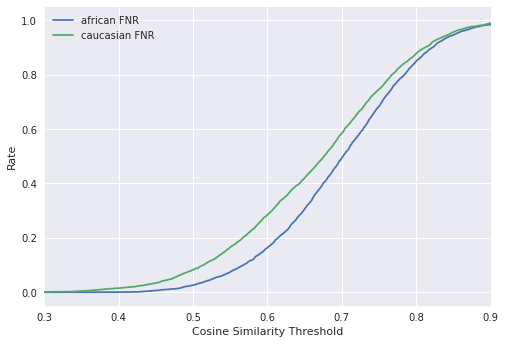

In [23]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,african_fnr_list,label='african FNR')
    plt.plot(thresholds,caucasian_fnr_list,label='caucasian FNR')
    plt.legend()
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.xlim(0.3,0.9)
plt.show()

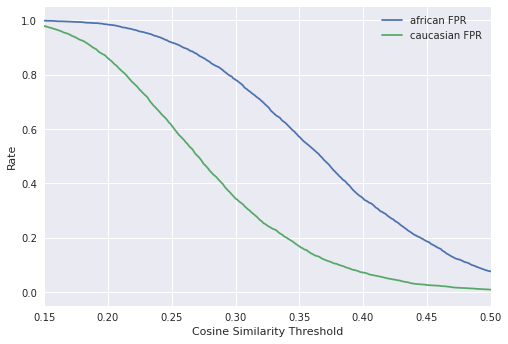

In [24]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,african_fpr_list,label='african FPR')
    plt.plot(thresholds,caucasian_fpr_list,label='caucasian FPR')
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    plt.legend()
    plt.xlim(0.15,0.5)
plt.show()

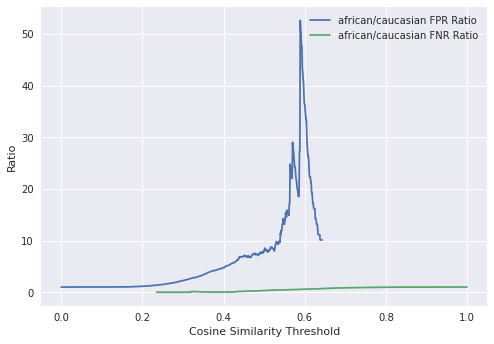

In [25]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,np.array(african_fpr_list)/np.array(caucasian_fpr_list),label='african/caucasian FPR Ratio')
    plt.plot(thresholds,np.array(african_fnr_list)/np.array(caucasian_fnr_list),label='african/caucasian FNR Ratio')
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Ratio')
    plt.legend()

plt.show()

In [26]:
len(african_fnr_list)

1001

### do all bias on validation set now

In [27]:
matches = df_val[df_val.labels==1]
non_matches = df_val[df_val.labels==0]
print(non_matches['reference_ethnicity'].value_counts())
print(matches['reference_ethnicity'].value_counts())

african      1438
caucasian    1431
Name: reference_ethnicity, dtype: int64
caucasian    1472
african      1414
Name: reference_ethnicity, dtype: int64


In [28]:
# bias on validation
val_cos = cos_sim(X_val[:,:2048],X_val[:,2048:])
thresholds = np.arange(0,1.001,0.001)
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []
acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    pred = (val_cos>thresh)*1
    tn, fp, fn, tp, acc = confusion_mat(pred, y_val.numpy())
    tnr_list.append(tn/(tn+fp))
    tpr_list.append(tp/(tp+fn))
    fnr_list.append(fn/(fn+tp))
    fpr_list.append(fp/(fp+tn))
    acc_list.append(acc)
f = np.array(fnr_list)-np.array(fpr_list)
z = solve(f,thresholds)
ans = interp(f,thresholds,z)
ans

  0%|          | 0/1001 [00:00<?, ?it/s]

array([0.49381289])

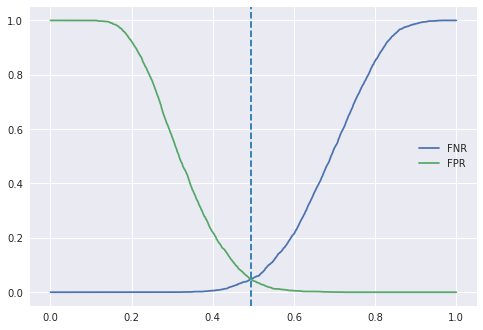

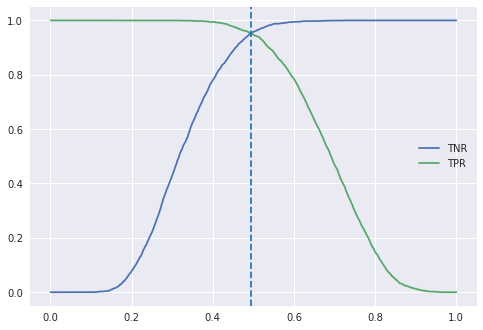

0.494
[0.498]


In [29]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,fnr_list,label='FNR')
    plt.plot(thresholds,fpr_list,label='FPR')
    # plt.plot(thresholds,np.array(fnr_list)-np.array(fpr_list))
    plt.axvline(x=ans,linestyle ='--')
    plt.legend()
plt.show()
with plt.style.context('seaborn'):    
    plt.plot(thresholds,tnr_list,label='TNR')
    plt.plot(thresholds,tpr_list,label='TPR')
    plt.legend()
    plt.axvline(x=ans,linestyle ='--')
plt.show()
print(thresholds[np.abs(thresholds-ans).argmin()])
print(thresholds[acc_list == max(acc_list)])


In [30]:
eer_thresh = 0.493
acc_thresh = 0.497
eer_pred = (val_cos>eer_thresh)*1
acc_pred = (val_cos>acc_thresh)*1
df_bias = df_val.drop(['reference_identity','candidate_identity','candidate_ethnicity'],axis=1)
df_bias['eer_pred'] = eer_pred
df_bias['acc_pred'] = acc_pred
df_bias_african = df_bias[df_bias['reference_ethnicity']=='african']
df_bias_caucasian = df_bias[df_bias['reference_ethnicity']=='caucasian']

african_eer_tn, african_eer_fp, african_eer_fn, african_eer_tp, african_eer_acc = confusion_mat(df_bias_african['eer_pred'], df_bias_african['labels'])
caucasian_eer_tn, caucasian_eer_fp, caucasian_eer_fn, caucasian_eer_tp, caucasian_eer_acc = confusion_mat(df_bias_caucasian['eer_pred'], df_bias_caucasian['labels'])

african_acc_tn, african_acc_fp, african_acc_fn, african_acc_tp, african_acc_acc = confusion_mat(df_bias_african['acc_pred'], df_bias_african['labels'])
caucasian_acc_tn, caucasian_acc_fp, caucasian_acc_fn, caucasian_acc_tp, caucasian_acc_acc = confusion_mat(df_bias_caucasian['acc_pred'], df_bias_caucasian['labels'])



In [32]:
african_eer_tnr = african_eer_tn/(african_eer_tn+african_eer_fp)
african_eer_tpr = african_eer_tp/(african_eer_tp+african_eer_fn)
african_eer_fnr = african_eer_fn/(african_eer_fn+african_eer_tp)
african_eer_fpr = african_eer_fp/(african_eer_tn+african_eer_fp)

caucasian_eer_tnr = caucasian_eer_tn/(caucasian_eer_tn+caucasian_eer_fp)
caucasian_eer_tpr = caucasian_eer_tp/(caucasian_eer_tp+caucasian_eer_fn)
caucasian_eer_fnr = caucasian_eer_fn/(caucasian_eer_fn+caucasian_eer_tp)
caucasian_eer_fpr = caucasian_eer_fp/(caucasian_eer_tn+caucasian_eer_fp)

print(african_eer_fnr/caucasian_eer_fnr)
print(african_eer_fpr/caucasian_eer_fpr)
print(caucasian_eer_tnr/african_eer_tnr)
print(caucasian_eer_tpr/african_eer_tpr)
print((1-african_eer_acc)/(1-caucasian_eer_acc))

0.34033293439234036
26.470514603616135
1.0980655491029234
0.9522448015122874
1.5595075723458185


In [33]:
print('african fnr:',african_eer_fnr,'caucasian fnr:',caucasian_eer_fnr)
print('african fpr:',african_eer_fpr,'caucasian fpr:',caucasian_eer_fpr)
print('african tnr:',caucasian_eer_tnr,'caucasian tnr:',african_eer_tnr)
print('african tpr:',caucasian_eer_tpr,'caucasian tpr:',african_eer_tpr)
print('african mis class:',(1-african_eer_acc),'caucasian mis class:',(1-caucasian_eer_acc))

african fnr: 0.024045261669024046 caucasian fnr: 0.07065217391304347
african fpr: 0.09248956884561892 caucasian fpr: 0.0034940600978336828
african tnr: 0.9965059399021663 caucasian tnr: 0.9075104311543811
african tpr: 0.9293478260869565 caucasian tpr: 0.9759547383309759
african mis class: 0.05855539971949508 caucasian mis class: 0.03754736479503962


In [34]:
african_acc_tnr = african_acc_tn/(african_acc_tn+african_acc_fp)
african_acc_tpr = african_acc_tp/(african_acc_tp+african_acc_fn)
african_acc_fnr = african_acc_fn/(african_acc_fn+african_acc_tp)
african_acc_fpr = african_acc_fp/(african_acc_tn+african_acc_fp)

caucasian_acc_tnr = caucasian_acc_tn/(caucasian_acc_tn+caucasian_acc_fp)
caucasian_acc_tpr = caucasian_acc_tp/(caucasian_acc_tp+caucasian_acc_fn)
caucasian_acc_fnr = caucasian_acc_fn/(caucasian_acc_fn+caucasian_acc_tp)
caucasian_acc_fpr = caucasian_acc_fp/(caucasian_acc_tn+caucasian_acc_fp)

print(african_acc_fnr/caucasian_acc_fnr)
print(african_acc_fpr/caucasian_acc_fpr)
print(caucasian_acc_tnr/african_acc_tnr)
print(caucasian_acc_tpr/african_acc_tpr)
print((1-african_acc_acc)/(1-caucasian_acc_acc))

0.3342719593060224
24.480250347705148
1.0897152407447264
0.9494523835797837
1.41074899731798


In [35]:
print('african fnr:',african_acc_fnr,'caucasian fnr:',caucasian_acc_fnr)
print('african fpr:',african_acc_fpr,'caucasian fpr:',caucasian_acc_fpr)
print('african tnr:',caucasian_acc_tnr,'caucasian tnr:',african_acc_tnr)
print('african tpr:',caucasian_acc_tpr,'caucasian tpr:',african_acc_tpr)
print('african acc:',(1-african_acc_acc),'caucasian acc:',(1-caucasian_acc_acc))

african fnr: 0.024752475247524754 caucasian fnr: 0.07404891304347826
african fpr: 0.08553546592489569 caucasian fpr: 0.0034940600978336828
african tnr: 0.9965059399021663 caucasian tnr: 0.9144645340751043
african tpr: 0.9259510869565217 caucasian tpr: 0.9752475247524752
african acc: 0.05539971949509115 caucasian acc: 0.039269720978298284


In [36]:
val_cos = cos_sim(X_val[:,:2048],X_val[:,2048:])
african_val_cos = val_cos[ethnicity_val=='african']
caucasian_val_cos = val_cos[ethnicity_val=='caucasian']


thresholds = np.arange(0,1.001,0.001)
african_tpr_list = []
african_tnr_list = []
african_fpr_list = []
african_fnr_list = []
african_acc_list = []

caucasian_tpr_list = []
caucasian_tnr_list = []
caucasian_fpr_list = []
caucasian_fnr_list = []
caucasian_acc_list = []
for thresh in tqdm_notebook(thresholds,total=len(thresholds)):
    african_pred = (african_val_cos>thresh)*1
    african_tn, african_fp, african_fn, african_tp, african_acc = confusion_mat(african_pred, y_val[ethnicity_val=='african'].numpy())
    african_tnr_list.append(african_tn/(african_tn+african_fp))
    african_tpr_list.append(african_tp/(african_tp+african_fn))
    african_fnr_list.append(african_fn/(african_fn+african_tp))
    african_fpr_list.append(african_fp/(african_fp+african_tn))
    african_acc_list.append(african_acc)

    caucasian_pred = (caucasian_val_cos>thresh)*1
    caucasian_tn, caucasian_fp, caucasian_fn, caucasian_tp, caucasian_acc = confusion_mat(caucasian_pred, y_val[ethnicity_val=='caucasian'].numpy())
    caucasian_tnr_list.append(caucasian_tn/(caucasian_tn+caucasian_fp))
    caucasian_tpr_list.append(caucasian_tp/(caucasian_tp+caucasian_fn))
    caucasian_fnr_list.append(caucasian_fn/(caucasian_fn+caucasian_tp))
    caucasian_fpr_list.append(caucasian_fp/(caucasian_fp+caucasian_tn))
    caucasian_acc_list.append(caucasian_acc)

  0%|          | 0/1001 [00:00<?, ?it/s]

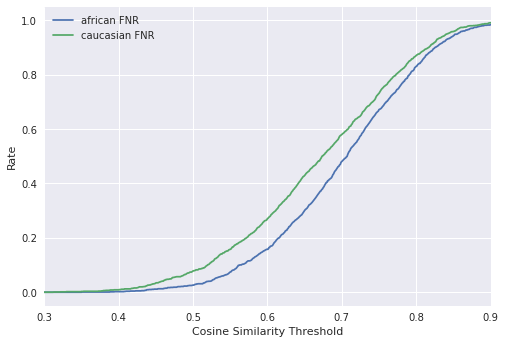

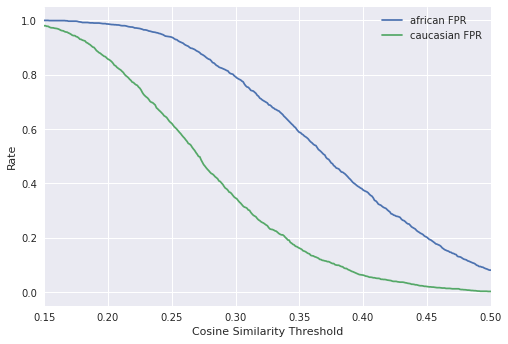

In [37]:
with plt.style.context('seaborn'):    
    plt.plot(thresholds,african_fnr_list,label='african FNR')
    plt.plot(thresholds,caucasian_fnr_list,label='caucasian FNR')
    plt.legend()
    plt.xlim(0.3,0.9)
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
plt.show()

with plt.style.context('seaborn'):    
    plt.plot(thresholds,african_fpr_list,label='african FPR')
    plt.plot(thresholds,caucasian_fpr_list,label='caucasian FPR')
    plt.legend()
    plt.xlim(0.15,0.5)
    plt.xlabel('Cosine Similarity Threshold')
    plt.ylabel('Rate')
    
plt.show()

In [38]:
matches = df_test[df_test.labels==1]
non_matches = df_test[df_test.labels==0]
print(non_matches['reference_ethnicity'].value_counts())
print(matches['reference_ethnicity'].value_counts())

african      1433
caucasian    1389
Name: reference_ethnicity, dtype: int64
african      1504
caucasian    1430
Name: reference_ethnicity, dtype: int64
